# Dask Array

Материалы:
* Макрушин С.В. Лекция 11: Dask
* https://docs.dask.org/en/latest/array.html
* JESSE C. DANIEL. Data Science with Python and Dask. 

In [1]:
from pathlib import Path

import dask.array as da
import h5py
import numpy as np

In [2]:
DATA_DIR = Path('data/')
OUTPUT_DIR = Path('output/')
if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir()

## Задачи для совместного разбора

1. Создайте массив размерностью 1000 на 300000, заполненный числами из стандартного нормального распределения. Исследуйте основные характеристики полученного массива.

In [3]:
%%time

da_arr = da.random.normal(size=(1000, 300_000), chunks=(1000, 30_000))
da_arr

Wall time: 2.2 ms


dask.array<normal, shape=(1000, 300000), dtype=float64, chunksize=(1000, 30000), chunktype=numpy.ndarray>

2. Посчитайте сумму квадратов элементов массива, созданного в задаче 1. Создайте массив `np.array` такого же размера и сравните скорость решения задачи с использование `da.array` и `np.array`

In [4]:
%%time

graph = da.power(da_arr, 2).sum()

Wall time: 4 ms


In [5]:
%%time

graph.compute()

Wall time: 5.38 s


300020577.32682604

In [6]:
%%time

np_arr = np.random.normal(size=(1000, 300_000))

Wall time: 7.47 s


In [7]:
%%time

np.power(np_arr, 2).sum()

Wall time: 11 s


299985492.73435694

3. Визуализируйте граф вычислений для задачи 12.

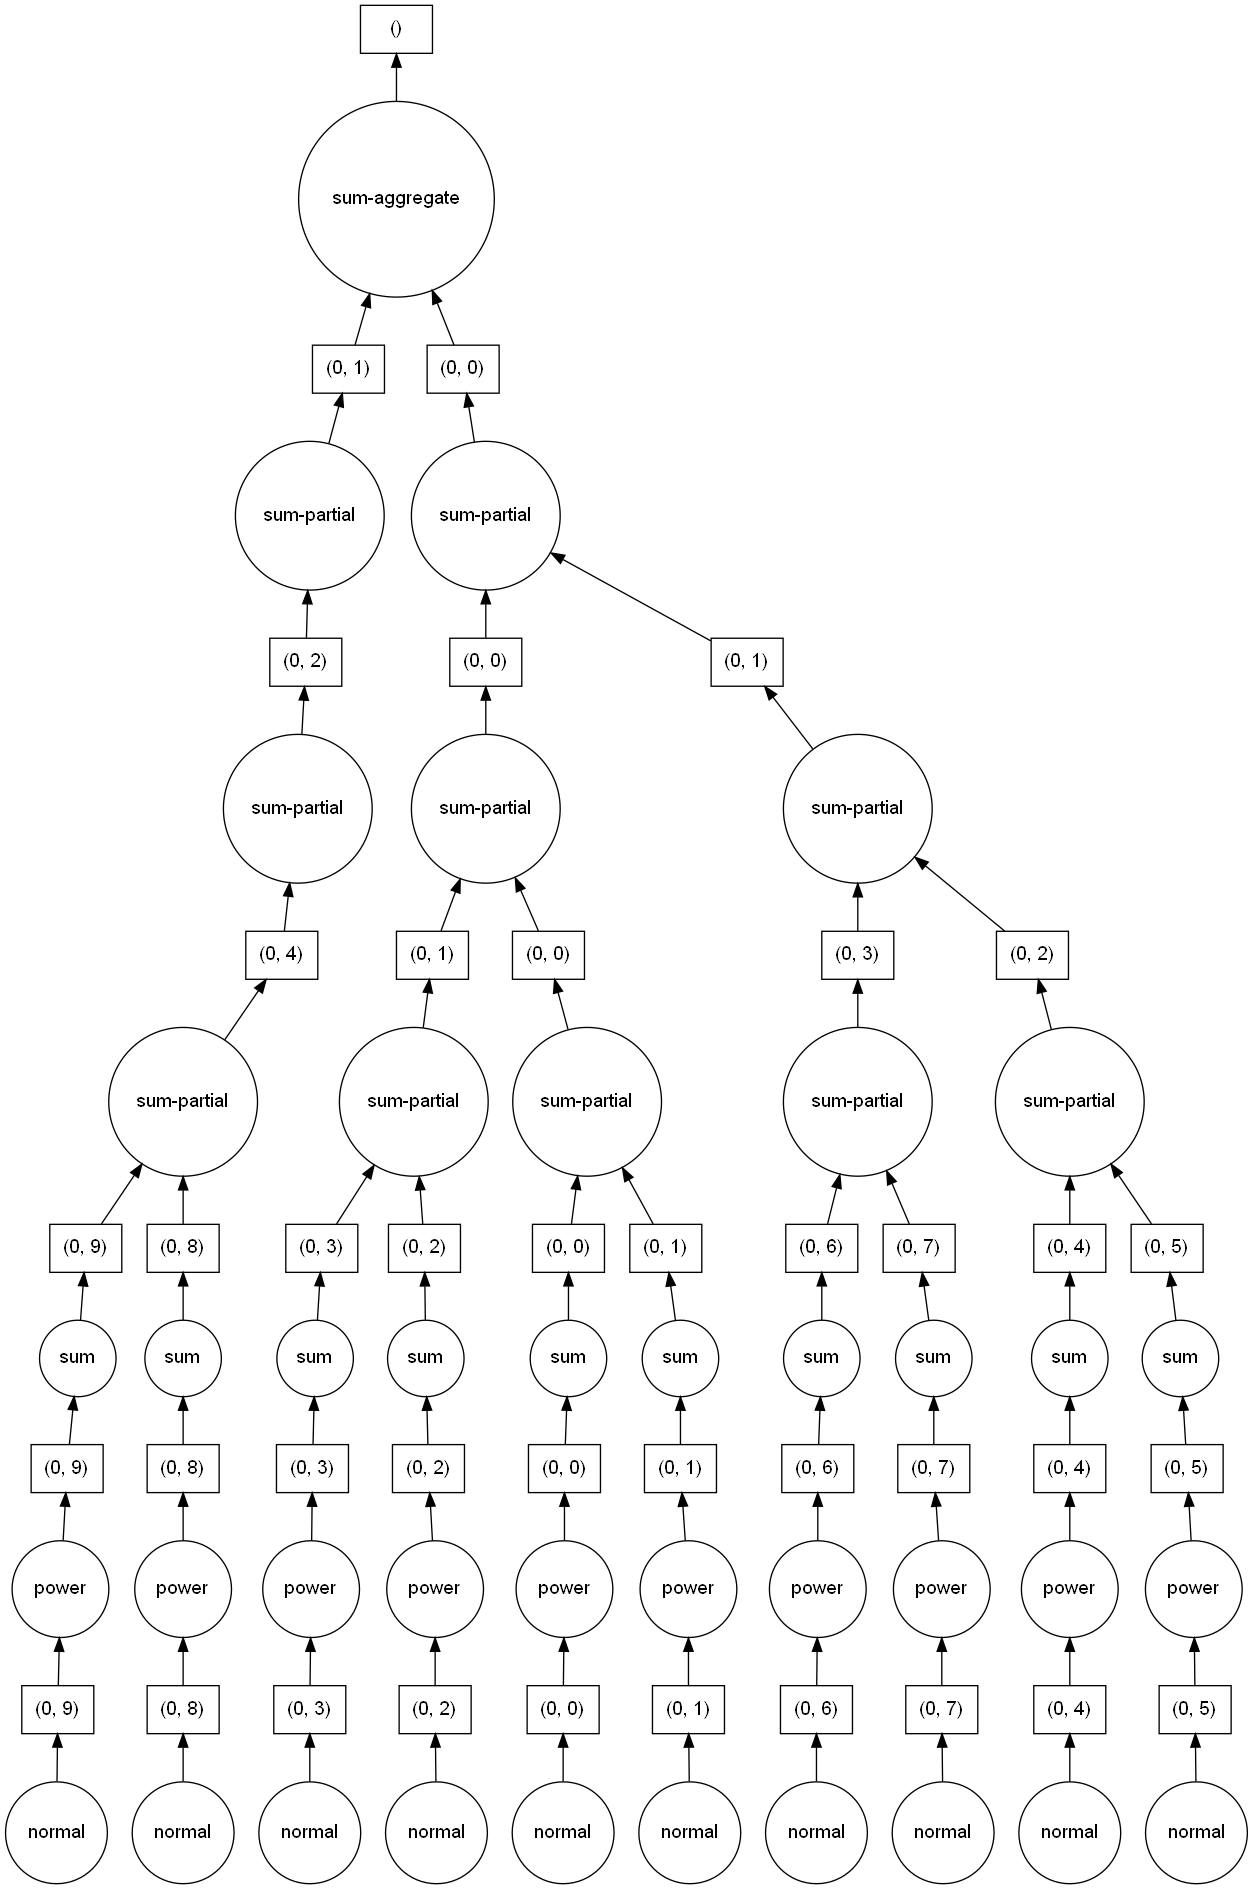

In [8]:
graph.visualize(filename=str(OUTPUT_DIR.joinpath('graph_3.png')))

## Лабораторная работа 11

1. Считайте датасет `recipe` из файла `minutes_n_ingredients_full.hdf5` в виде `dask.array`. Укажите аргумент `chunks=(100_000, 3)` при создании массива. Выведите на экран основную информацию о массиве.

In [9]:
recipes = da.from_array(
    h5py.File(DATA_DIR.joinpath('minutes_n_ingredients_full.hdf5'))['recipe'],
    chunks=(100_000, 3)
).astype(np.int32)
recipes

dask.array<astype, shape=(2231637, 3), dtype=int32, chunksize=(100000, 3), chunktype=numpy.ndarray>

2. Вычислите среднее значение по каждому столбцу, кроме первого. 

In [10]:
result = recipes[:, 1:].mean(axis=0).compute()
result

array([1004.20805176,    5.4198008 ])

3. Исследуйте, как влияет значение аргумента `chunks` при создании `dask.array` на скорость выполнения операции поиска среднего. 

In [11]:
def mean(arr: da.Array) -> np.ndarray:
    return arr.mean(axis=0).compute()

In [12]:
%timeit mean(recipes)

34 ms ± 509 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
_recipes = recipes.rechunk((500_000, 10))
%timeit mean(_recipes)

44.7 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
_recipes = recipes.rechunk((100_000, 90_000))
%timeit mean(_recipes)

47.9 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
_recipes = recipes.rechunk('auto')
%timeit mean(_recipes)

82.6 ms ± 715 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
_recipes = recipes.rechunk((10_000, 10_000))
%timeit mean(_recipes)

101 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
_recipes = recipes.rechunk((100, 1_000))
%timeit mean(_recipes)

6.38 s ± 183 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


4. Выберите рецепты, время выполнения которых меньше медианного значения

In [18]:
minutes = recipes[:, 1]
recipes[minutes < da.median(minutes, axis=0)].compute()

array([[1089012,      23,       5],
       [1428572,       0,       5],
       [1400250,      24,       1],
       ...,
       [1029131,      19,       4],
       [1700703,       1,       1],
       [ 713836,       0,       9]])

5. Посчитайте количество каждого из возможных значений кол-ва ингредиентов

In [19]:
unique, counts = da.unique(recipes[:, 2], return_counts=True)
da.hstack([da.from_array([unique]).T, da.from_array([counts]).T]).compute()[:10]

array([[     1, 222071],
       [     2, 224158],
       [     3, 229388],
       [     4, 234948],
       [     5, 240720],
       [     6, 244360],
       [     7, 247181],
       [     8, 246747],
       [     9, 246816],
       [    10,  22430]], dtype=int64)

6. Найдите максимальную продолжительность рецепта. Ограничьте максимальную продолжительность рецептов сверху значением, равному 75% квантилю.

In [20]:
minutes_max = recipes[:, 1].max().compute()
minutes_max

2147483647

In [21]:
recipes_modified = recipes.copy()
minutes = recipes_modified[:, 1].compute()
q_75 = np.quantile(minutes, 0.75)
recipes_modified[:, 1] = da.where(minutes <= q_75, minutes, q_75)
recipes_modified = recipes_modified.compute()
recipes_modified

array([[ 683970,      33,       9],
       [1089012,      23,       5],
       [1428572,       0,       5],
       ...,
       [1910650,      49,       2],
       [ 713836,       0,       9],
       [ 660699,      49,       8]])

In [22]:
recipes_modified[:, 1].max()

49

7. Создайте массив `dask.array` из 2 чисел, содержащих ваши предпочтения относительно времени выполнения рецепта и кол-ва ингредиентов. Найдите наиболее похожий (в смысле $L_1$) рецепт из имеющихся в датасете.

In [23]:
target = da.array([10, 4])

In [24]:
l1_metric = da.linalg.norm(recipes[:, 1:] - target, ord=1, axis=1)
most_similar = recipes[l1_metric.argmin()].compute()
most_similar

array([144542,     10,      4])

8. Работая с исходным файлом в формате `hdf5`, реализуйте алгоритм подсчета среднего значения в блочной форме и вычислите с его помощью среднее значение второго столбца в массиве.

Блочный алгоритм вычислений состоит из двух частей:
1. Загрузка фрагмента за фрагментом данных по `blocksize` элементов и проведение вычислений на этим фрагментом
2. Агрегация результатов вычислений на различных фрагментах для получения результата на уровне всего набора данных

Важно: при работе с `h5py` в память загружаются не все элементы, а только те, которые запрашиваются в данный момент

In [25]:
def aggregate(sum_list: list, count_list: list) -> float:
    return sum(sum_list) / sum(count_list)

In [26]:
def chunk_read(h5_file: str, blocksize: int) -> np.ndarray:
    with h5py.File(h5_file) as f:
        dataset = f['recipe']
        for i in range(0, dataset.shape[0], blocksize):
            yield dataset[i:i + blocksize, 1]

In [27]:
def block_algorithm(h5_file: str, blocksize: int = 100_000) -> float:
    sum_list = []
    cnt_list = []
    for chunk in chunk_read(h5_file, blocksize):
        sum_list.append(chunk.sum())
        cnt_list.append(chunk.size)
    return aggregate(sum_list, cnt_list)

In [28]:
block_algorithm(
    DATA_DIR.joinpath('minutes_n_ingredients_full.hdf5'),
    blocksize=100_000
)


1004.2080517575215